In [ ]:
#credits
https://towardsdatascience.com/predicate-vs-projection-pushdown-in-spark-3-ac24c4d11855
    https://www.bmc.com/blogs/python-spark-k-means-example/
- sampling: https://stackoverflow.com/questions/24806084/sampling-a-large-distributed-data-set-using-pyspark-spark
- filter pushing:

In [1]:
!pip install pyspark



In [1]:
from pyspark.sql import SparkSession


In [2]:
import glob

In [3]:
pwd()

'D:\\Bitcoin analysis'

In [4]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, TimestampType

In [5]:
from pyspark.sql import functions as F
#df.select(F.col("my_column"))

In [6]:
schema = StructType([ \
    StructField("value",IntegerType(),True), \
    StructField("fee",IntegerType(),True), \
    StructField("timestamp_in_unix_seconds",IntegerType(),True), \
  ])

In [7]:

# spark config
from pyspark.conf import SparkConf

config = SparkConf().setAll([ \
    ('spark.executor.memory', '8g'), \
    ('spark.executor.instances', '4'), \
    ('spark.driver.memory','16g'), \
    ("spark.sql.parquet.filterPushdown", "true"), \
    ("spark.hadoop.parquet.filter.stats.enabled", "true"), \
    ("spark.sql.optimizer.nestedSchemaPruning.enabled", "true"), \
    ("spark.sql.optimizer.dynamicPartitionPruning.enabled", "true") ])\
#    ("spark.executor.memoryOverhead", "16384") \





In [8]:
print(config.setMaster("local").setAppName("Clustering using K-Means"))

print(config.get("spark.master"))

print(config.get("spark.app.name"))


local
Clustering using K-Means


In [9]:
import time

from datetime import datetime
spark = SparkSession.builder.appName("Clustering using K-Means") \
    .config(conf=config) \
    .getOrCreate() \
#    .option("failOnDataLoss", False)
#spark

In [10]:
spark

In [11]:
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.executor.instances', '4'),
 ('spark.app.startTime', '1637775695621'),
 ('spark.sql.parquet.filterPushdown', 'true'),
 ('spark.app.id', 'local-1637775699221'),
 ('spark.driver.port', '51553'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.optimizer.dynamicPartitionPruning.enabled', 'true'),
 ('spark.driver.memory', '16g'),
 ('spark.sql.optimizer.nestedSchemaPruning.enabled', 'true'),
 ('spark.sql.warehouse.dir', 'file:/D:/Bitcoin%20analysis/spark-warehouse'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.memory', '8g'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.hadoop.parquet.filter.stats.enabled', 'true'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Clustering using K-Means'),
 ('spark.driver.host', '10.0.7.40')]

In [12]:
import glob
import os
BITCOIN_PATHS = sorted(glob.glob(os.path.join("D:\\Downloads\\bitcoin_data_filtered\\", "*")))
BITCOIN_PATHS

['D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000000',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000001',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000002',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000003',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000004',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000005',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000006',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000007',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000008',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000009',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000010',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000011',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000012',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000013',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000014',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000015',
 'D:\\Do

In [13]:
# hier wird dataframe gelesen. versuche es mit rdd .rdd()
data_customer=spark.read.csv(BITCOIN_PATHS, header=True, schema=schema) \
    .select("value","fee") \
     .filter((F.col('timestamp_in_unix_seconds') >= int(time.mktime(datetime.strptime('2021-04-13', '%Y-%m-%d').timetuple()))) & (F.col('timestamp_in_unix_seconds') <= int(time.mktime(datetime.strptime('2021-07-21', '%Y-%m-%d').timetuple())))) \
    .persist()
data_customer.printSchema()

root
 |-- value: integer (nullable = true)
 |-- fee: integer (nullable = true)



In [14]:
data_customer.explain()

== Physical Plan ==
*(1) ColumnarToRow
+- InMemoryTableScan [value#0, fee#1]
      +- InMemoryRelation [value#0, fee#1], StorageLevel(disk, memory, deserialized, 1 replicas)
            +- *(1) Project [value#0, fee#1]
               +- *(1) Filter ((isnotnull(timestamp_in_unix_seconds#2) AND (timestamp_in_unix_seconds#2 >= 1618264800)) AND (timestamp_in_unix_seconds#2 <= 1626818400))
                  +- FileScan csv [value#0,fee#1,timestamp_in_unix_seconds#2] Batched: false, DataFilters: [isnotnull(timestamp_in_unix_seconds#2), (timestamp_in_unix_seconds#2 >= 1618264800), (timestamp_..., Format: CSV, Location: InMemoryFileIndex[file:/D:/Downloads/bitcoin_data_filtered/bitcoin000000000000, file:/D:/Download..., PartitionFilters: [], PushedFilters: [IsNotNull(timestamp_in_unix_seconds), GreaterThanOrEqual(timestamp_in_unix_seconds,1618264800), ..., ReadSchema: struct<value:int,fee:int,timestamp_in_unix_seconds:int>




In [15]:
data_customer=data_customer.na.drop()

In [16]:
data_customer.show(2)

+--------+-----+
|   value|  fee|
+--------+-----+
|39858391|57109|
| 4605511|46462|
+--------+-----+
only showing top 2 rows



In [17]:
data_customer = data_customer.sample(False,0.0001,1234)

In [18]:
inputCols=[ 'value', 'fee']

In [19]:
# transformation task. genau wie filter, join, etc. --> bis hier wird das aber nur vorbereitet
from pyspark.ml.feature import VectorAssembler
data_customer.columns
assemble=VectorAssembler(inputCols=[ 'value', 'fee'], outputCol='features')
assembled_data=assemble.transform(data_customer)
assembled_data.show(2)

+-------+----+------------------+
|  value| fee|          features|
+-------+----+------------------+
| 624825|6016| [624825.0,6016.0]|
|2851450|7810|[2851450.0,7810.0]|
+-------+----+------------------+
only showing top 2 rows



In [20]:
# an dieser stelle findet erstmals eine aktion statt. die vorbereiteten transformationen werden durchgeführt.
#standarizer
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized', withMean=True, withStd=True)
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+-------+----+------------------+--------------------+
|  value| fee|          features|        standardized|
+-------+----+------------------+--------------------+
| 624825|6016| [624825.0,6016.0]|[-0.2942127824004...|
|2851450|7810|[2851450.0,7810.0]|[-0.2828374556354...|
+-------+----+------------------+--------------------+
only showing top 2 rows



In [21]:
#data_customer = data_scale_output.toPandas()

In [22]:
%%time
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i, seed=1) # set seed
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.947831148074283
Silhouette Score: 0.9638051619369279
Silhouette Score: 0.9213237542834212
Silhouette Score: 0.9502520786896353
Silhouette Score: 0.9124334492122876
Silhouette Score: 0.8744301817171122
Silhouette Score: 0.9132884094423092
Silhouette Score: 0.8476193349404975
Wall time: 9min 48s


Text(0, 0.5, 'silhouette score')

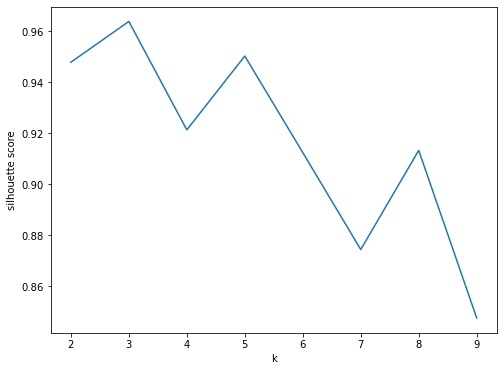

In [23]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score) # passe range an grösse des k an
ax.set_xlabel("k")
ax.set_ylabel("silhouette score")

In [24]:
type(data_customer)

pyspark.sql.dataframe.DataFrame

In [22]:



from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

# Trains a k-means model.
kmeans = KMeans(featuresCol='standardized').setK(4).setSeed(1)
model = kmeans.fit(data_scale_output)

# Make predictions
predictions = model.transform(data_scale_output)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()


silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette)) 
# evaluation mit silhouette; evaluation mit SSE ist depriciated



Silhouette with squared euclidean distance = 0.9309220518283086


In [23]:
# Shows the result.
print("Cluster Centers: ")
ctr=[]
centers = model.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)

Cluster Centers: 
[-0.21412001 -0.08271716]
[5.66902478 0.2016853 ]
[ 2.06258003 17.97238902]
[1.61858308 0.7302794 ]


In [24]:
# output of transform "output" or "predictions"
pandasDF=predictions.toPandas()

In [34]:
import pandas as pd
centers = pd.DataFrame(ctr,columns=inputCols)
centers # könnte man einzeichnen, wenn man plot mit skalierten daten (nicht pca -daten) macht

,value,fee
0,-0.236152,-0.050440
1,5.323349,0.082438
2,1.759940,0.453161
3,1.083775,25.283918


In [25]:
# bring scaled values(value, fee) into list
x = []
y = []
for i, j in pandasDF["standardized"].values:
    x.append(i)
    y.append(j)

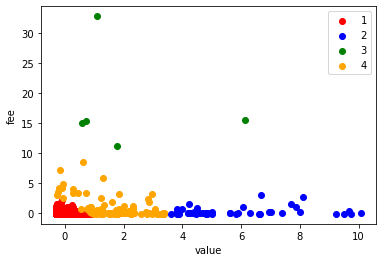

In [53]:
import matplotlib.pyplot as plt

# plot mit scaled daten: value vs. fee
#todo: outlier entfernen
#todo: mean centers rein tun
import numpy as np
scatter_x = np.array(x) # scaled bitcoin transaction value
scatter_y = np.array(y) # scaled bitcoin transaction fee
group = np.array(pandasDF['prediction'])

cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'}
fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g+1)
ax.legend()
plt.xlabel("value")
plt.ylabel("fee")
plt.show()

#plt.scatter(y=pandasDF["fee"],x=pandasDF["value"], c=pandasDF["prediction"], cmap='brg')
#plt.legend()

#plt.scatter(y=y,x=x, c=pandasDF["prediction"].values, cmap='brg')
#plt.legend()




In [30]:
# interpretation:
- 2010-2011 waren fees sehr günstig. zum teil waren transaktionen auch gratis. daher ist fee relativ weit unten
- fee plot ist auch etwas gezerrt wegen outlier oben
- die drei cluster
-- transaktionen mit wenig fee und wenig betrag
-- transaktionen mit wenig fee und viel betrag
-- transaktionen mit etwas höherem fees haben etwas höheren betrag

SyntaxError: invalid syntax (<ipython-input-30-a0ef6d29c5d6>, line 2)

In [31]:
# bezug zu orignaldaten machen: im folgenden wird nicht mit skalierten werten gearbeitet, damit mehr einblick in daten möglich wird

In [55]:
class1 = pandasDF.loc[pandasDF['prediction'] == 0]
class2 = pandasDF.loc[pandasDF['prediction'] == 1]
class3 = pandasDF.loc[pandasDF['prediction'] == 2]
class4 = pandasDF.loc[pandasDF['prediction'] == 3]

{'whiskers': [<matplotlib.lines.Line2D at 0x1f2104c5220>,
 'caps': [<matplotlib.lines.Line2D at 0x1f21061e1f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f2104a2550>,
 'medians': [<matplotlib.lines.Line2D at 0x1f210618910>,
 'fliers': [<matplotlib.lines.Line2D at 0x1f210618b80>,
 'means': []}

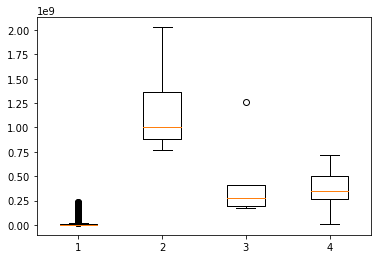

In [56]:
plt.boxplot([class1["value"], class2["value"], class3["value"],  class4["value"]])

{'whiskers': [<matplotlib.lines.Line2D at 0x1f21076eca0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f21077c3a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f21076e940>,
 'medians': [<matplotlib.lines.Line2D at 0x1f21077ca00>,
 'fliers': [<matplotlib.lines.Line2D at 0x1f21077cd60>,
 'means': []}

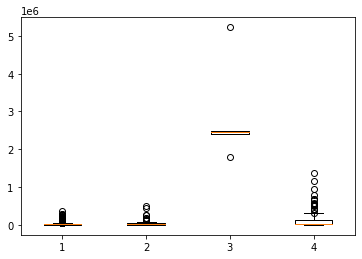

In [57]:
plt.boxplot([class1["fee"], class2["fee"], class3["fee"], class4["fee"]])

In [38]:
class1["value"].std()

36789394.075516514

In [39]:
class1["fee"].std()

26799.044073806057

In [40]:
class1["value"].mean()

16302315.593017915

In [41]:
class2["value"].std()

362871728.7096598

In [42]:
class2["fee"].std()

106870.12782444603

In [43]:
class1["fee"].mean()

18741.704639412033

In [44]:
class2["value"].mean()

1167878663.7959185

In [45]:
class2["fee"].mean()

63766.510204081635

In [46]:
class3["value"].std()

455062227.3899649

In [47]:
class3["fee"].std()

1344642.1685116824

In [48]:
class3["value"].mean()

461947291.4

In [49]:
class3["value"].mean()

461947291.4

array([[<AxesSubplot:title={'center':'value'}>,
        <AxesSubplot:title={'center':'fee'}>],
       [<AxesSubplot:title={'center':'prediction'}>, <AxesSubplot:>]],
      dtype=object)

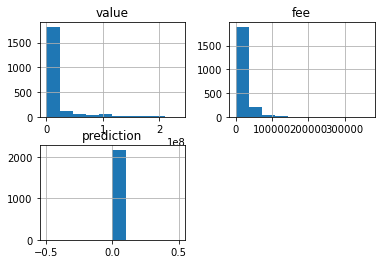

In [50]:
class1.hist()


array([[<AxesSubplot:title={'center':'value'}>,
        <AxesSubplot:title={'center':'fee'}>],
       [<AxesSubplot:title={'center':'prediction'}>, <AxesSubplot:>]],
      dtype=object)

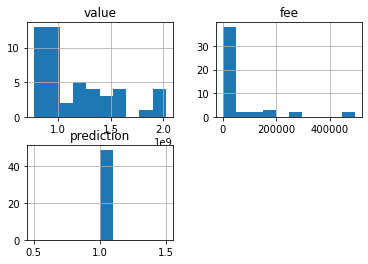

In [51]:
class2.hist()

In [52]:
class3.hist()p

SyntaxError: invalid syntax (<ipython-input-52-48df3de84d2c>, line 1)